ЧАСТЬ 1: ЛИНЕЙНАЯ РЕГРЕССИЯ


100%|██████████| 500/500 [00:00<00:00, 1751.80it/s]



Результаты линейной регрессии:
MSE на обучении: 0.4462
MSE на тесте: 0.5155


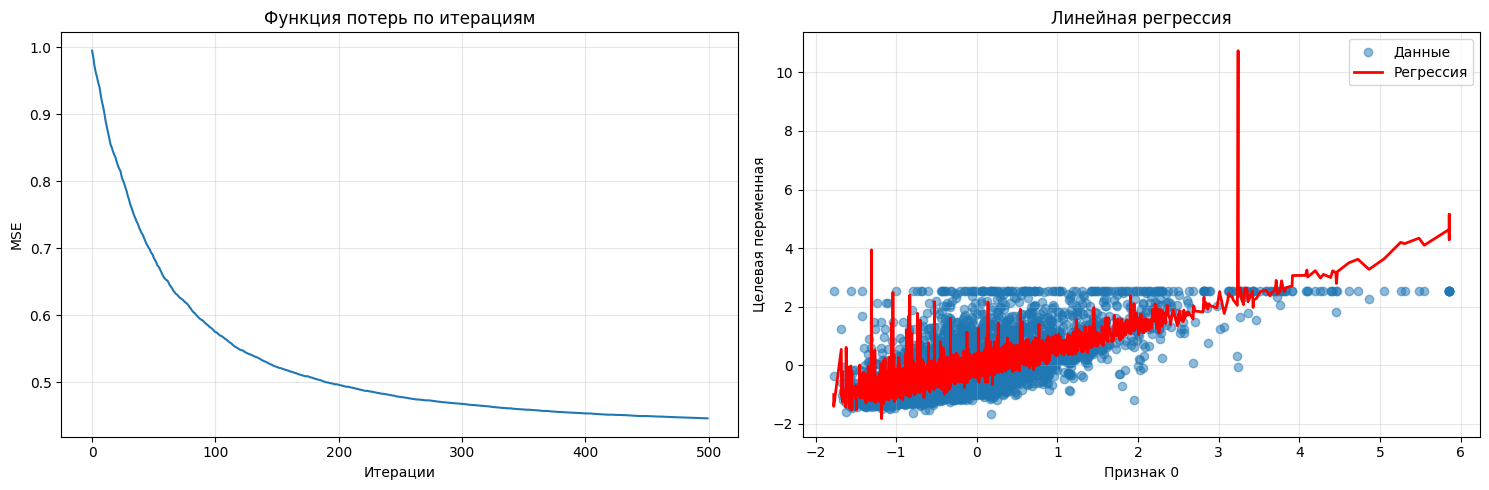

Коэффициенты: [ 0.78124008  0.20417077  0.09191978  0.19825542 -0.03263453]
Интерсепт: 0.0023
Финальная MSE: 0.4462

ЧАСТЬ 2: ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
Порог для дорогого жилья: $264725
Процент дорогих домов: 25.0%


100%|██████████| 500/500 [00:00<00:00, 827.82it/s]



Результаты логистической регрессии:
Accuracy: 0.8321
Precision: 0.7839
Recall: 0.4535
F1-Score: 0.5746


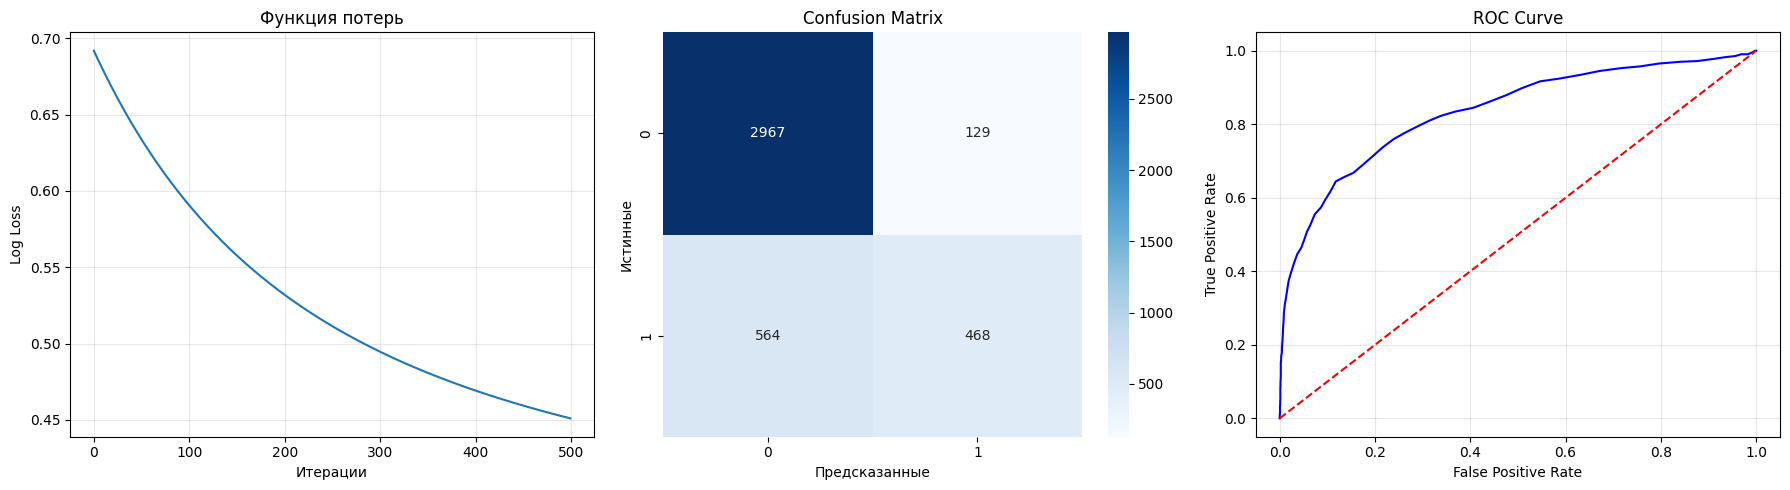


ЧАСТЬ 3: СРАВНЕНИЕ С DECISION TREE

Результаты Decision Tree:
Accuracy: 0.8624
Precision: 0.7768
Recall: 0.6308
F1-Score: 0.6963

СРАВНЕНИЕ МОДЕЛЕЙ
Метрика         Лог.Регрессия   Decision Tree  
---------------------------------------------
Accuracy        0.8321          0.8624         
Precision       0.7839          0.7768         
Recall          0.4535          0.6308         
F1-Score        0.5746          0.6963         


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import plotly.graph_objects as go
import plotly.express as px
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown
from tqdm import tqdm

# Загрузка данных
data = pd.read_csv('housing.csv')

# Предобработка данных
def preprocess_data(df):
    """Предобработка данных"""
    df = df.copy()

    # Обработка пропущенных значений
    df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].median())

    # Кодирование категориальных признаков
    df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)

    # Создание новых признаков
    df['rooms_per_household'] = df['total_rooms'] / df['households']
    df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
    df['population_per_household'] = df['population'] / df['households']

    return df

# Создание бинарной целевой переменной для классификации
def create_binary_target(df, threshold_percentile=75):
    """Создание бинарной целевой переменной (дорогое/дешевое жилье)"""
    threshold = np.percentile(df['median_house_value'], threshold_percentile)
    df['is_expensive'] = (df['median_house_value'] > threshold).astype(int)
    return df, threshold

# Линейная регрессия с нуля
class LinearRegressionGD:
    """Линейная регрессия с градиентным спуском"""

    def __init__(self, learning_rate=0.01, n_iter=1000, batch_size=None):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.loss_history = []

    def fit(self, X, y):
        """Обучение модели"""
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for iteration in tqdm(range(self.n_iter)):
            # Мини-батч градиентный спуск
            if self.batch_size and self.batch_size < n_samples:
                indices = np.random.choice(n_samples, self.batch_size, replace=False)
                X_batch = X[indices]
                y_batch = y[indices]
            else:
                X_batch = X
                y_batch = y

            # Прямое распространение
            y_pred = np.dot(X_batch, self.weights) + self.bias

            # Вычисление градиентов
            dw = (1/len(y_batch)) * np.dot(X_batch.T, (y_pred - y_batch))
            db = (1/len(y_batch)) * np.sum(y_pred - y_batch)

            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Вычисление потерь
            loss = self.compute_loss(X, y)
            self.loss_history.append(loss)

        return self

    def compute_loss(self, X, y):
        """Вычисление MSE"""
        y_pred = self.predict(X)
        return np.mean((y_pred - y) ** 2)

    def predict(self, X):
        """Предсказание"""
        return np.dot(X, self.weights) + self.bias

# Логистическая регрессия с нуля
class LogisticRegressionGD:
    """Логистическая регрессия с градиентным спуском"""

    def __init__(self, learning_rate=0.01, n_iter=1000, reg_strength=0.1):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.reg_strength = reg_strength
        self.weights = None
        self.bias = None
        self.loss_history = []

    def sigmoid(self, z):
        """Сигмоидная функция"""
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """Обучение модели"""
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for iteration in tqdm(range(self.n_iter)):
            # Прямое распространение
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            # Вычисление градиентов (с регуляризацией L2)
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y)) + (self.reg_strength/n_samples) * self.weights
            db = (1/n_samples) * np.sum(y_pred - y)

            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Вычисление потерь
            loss = self.compute_loss(X, y)
            self.loss_history.append(loss)

        return self

    def compute_loss(self, X, y):
        """Вычисление log loss"""
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear_model)

        # Log loss с регуляризацией L2
        log_loss = -np.mean(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))
        reg_loss = (self.reg_strength / (2 * len(y))) * np.sum(self.weights ** 2)

        return log_loss + reg_loss

    def predict_proba(self, X):
        """Вероятности предсказаний"""
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        """Бинарные предсказания"""
        return (self.predict_proba(X) >= threshold).astype(int)

# Визуализация
def plot_regression_results(X, y, model, feature_idx=0):
    """Визуализация результатов линейной регрессии"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # График функции потерь
    axes[0].plot(model.loss_history)
    axes[0].set_xlabel('Итерации')
    axes[0].set_ylabel('MSE')
    axes[0].set_title('Функция потерь по итерациям')
    axes[0].grid(True, alpha=0.3)

    # График регрессии
    x_vals = X[:, feature_idx]
    y_pred = model.predict(X)

    axes[1].scatter(x_vals, y, alpha=0.5, label='Данные')
    axes[1].plot(np.sort(x_vals), y_pred[np.argsort(x_vals)],
                color='red', linewidth=2, label='Регрессия')
    axes[1].set_xlabel(f'Признак {feature_idx}')
    axes[1].set_ylabel('Целевая переменная')
    axes[1].set_title('Линейная регрессия')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Вывод коэффициентов
    print(f"Коэффициенты: {model.weights}")
    print(f"Интерсепт: {model.bias:.4f}")
    print(f"Финальная MSE: {model.loss_history[-1]:.4f}")

def plot_classification_results(X_test, y_test, model, threshold=0.5):
    """Визуализация результатов классификации"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # График функции потерь
    axes[0].plot(model.loss_history)
    axes[0].set_xlabel('Итерации')
    axes[0].set_ylabel('Log Loss')
    axes[0].set_title('Функция потерь')
    axes[0].grid(True, alpha=0.3)

    # Confusion Matrix
    y_pred = model.predict(X_test, threshold)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_xlabel('Предсказанные')
    axes[1].set_ylabel('Истинные')
    axes[1].set_title('Confusion Matrix')

    # ROC Curve (приближенная)
    y_proba = model.predict_proba(X_test)
    thresholds = np.linspace(0, 1, 100)
    tpr_list = []
    fpr_list = []

    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    axes[2].plot(fpr_list, tpr_list, 'b-')
    axes[2].plot([0, 1], [0, 1], 'r--')
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')
    axes[2].set_title('ROC Curve')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Основной пайплайн
def run_experiment(data, learning_rate=0.01, n_iter=1000, batch_size=None):
    """Основной пайплайн эксперимента"""

    # 1. Предобработка данных
    df = preprocess_data(data)

    # 2. Линейная регрессия
    print("=" * 50)
    print("ЧАСТЬ 1: ЛИНЕЙНАЯ РЕГРЕССИЯ")
    print("=" * 50)

    # Выбор признаков для линейной регрессии
    features_reg = ['median_income', 'housing_median_age', 'total_rooms',
                   'bedrooms_per_room', 'population_per_household']
    X_reg = df[features_reg].values
    y_reg = df['median_house_value'].values

    # Масштабирование
    scaler_reg = StandardScaler()
    X_reg_scaled = scaler_reg.fit_transform(X_reg)
    y_reg_scaled = (y_reg - y_reg.mean()) / y_reg.std()

    # Разделение данных
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg_scaled, y_reg_scaled, test_size=0.2, random_state=42
    )

    # Обучение модели
    lr_model = LinearRegressionGD(
        learning_rate=learning_rate,
        n_iter=n_iter,
        batch_size=batch_size
    )
    lr_model.fit(X_train_reg, y_train_reg)

    # Оценка
    train_mse = lr_model.compute_loss(X_train_reg, y_train_reg)
    test_mse = lr_model.compute_loss(X_test_reg, y_test_reg)

    print(f"\nРезультаты линейной регрессии:")
    print(f"MSE на обучении: {train_mse:.4f}")
    print(f"MSE на тесте: {test_mse:.4f}")

    # Визуализация
    plot_regression_results(X_test_reg, y_test_reg, lr_model)

    # 3. Логистическая регрессия (бинарная классификация)
    print("\n" + "=" * 50)
    print("ЧАСТЬ 2: ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
    print("=" * 50)

    # Создание бинарной целевой переменной
    df, threshold = create_binary_target(df)
    print(f"Порог для дорогого жилья: ${threshold:.0f}")
    print(f"Процент дорогих домов: {df['is_expensive'].mean()*100:.1f}%")

    # Выбор признаков для классификации
    features_clf = ['median_income', 'housing_median_age', 'total_rooms',
                   'bedrooms_per_room', 'population_per_household',
                   'rooms_per_household']
    X_clf = df[features_clf].values
    y_clf = df['is_expensive'].values

    # Масштабирование
    scaler_clf = StandardScaler()
    X_clf_scaled = scaler_clf.fit_transform(X_clf)

    # Разделение данных
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
        X_clf_scaled, y_clf, test_size=0.2, random_state=42, stratify=y_clf
    )

    # Обучение логистической регрессии
    logreg_model = LogisticRegressionGD(
        learning_rate=learning_rate,
        n_iter=n_iter
    )
    logreg_model.fit(X_train_clf, y_train_clf)

    # Предсказания
    y_pred_logreg = logreg_model.predict(X_test_clf)

    # Вычисление метрик
    accuracy_logreg = accuracy_score(y_test_clf, y_pred_logreg)
    precision_logreg = precision_score(y_test_clf, y_pred_logreg)
    recall_logreg = recall_score(y_test_clf, y_pred_logreg)
    f1_logreg = f1_score(y_test_clf, y_pred_logreg)

    print(f"\nРезультаты логистической регрессии:")
    print(f"Accuracy: {accuracy_logreg:.4f}")
    print(f"Precision: {precision_logreg:.4f}")
    print(f"Recall: {recall_logreg:.4f}")
    print(f"F1-Score: {f1_logreg:.4f}")

    # Визуализация
    plot_classification_results(X_test_clf, y_test_clf, logreg_model)

    # 4. Сравнение с другой моделью (Decision Tree)
    print("\n" + "=" * 50)
    print("ЧАСТЬ 3: СРАВНЕНИЕ С DECISION TREE")
    print("=" * 50)

    # Обучение Decision Tree
    dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt_model.fit(X_train_clf, y_train_clf)

    # Предсказания
    y_pred_dt = dt_model.predict(X_test_clf)

    # Вычисление метрик
    accuracy_dt = accuracy_score(y_test_clf, y_pred_dt)
    precision_dt = precision_score(y_test_clf, y_pred_dt)
    recall_dt = recall_score(y_test_clf, y_pred_dt)
    f1_dt = f1_score(y_test_clf, y_pred_dt)

    print(f"\nРезультаты Decision Tree:")
    print(f"Accuracy: {accuracy_dt:.4f}")
    print(f"Precision: {precision_dt:.4f}")
    print(f"Recall: {recall_dt:.4f}")
    print(f"F1-Score: {f1_dt:.4f}")

    # Сравнение моделей
    print(f"\n{'='*50}")
    print("СРАВНЕНИЕ МОДЕЛЕЙ")
    print(f"{'='*50}")
    print(f"{'Метрика':<15} {'Лог.Регрессия':<15} {'Decision Tree':<15}")
    print(f"{'-'*45}")
    print(f"{'Accuracy':<15} {accuracy_logreg:<15.4f} {accuracy_dt:<15.4f}")
    print(f"{'Precision':<15} {precision_logreg:<15.4f} {precision_dt:<15.4f}")
    print(f"{'Recall':<15} {recall_logreg:<15.4f} {recall_dt:<15.4f}")
    print(f"{'F1-Score':<15} {f1_logreg:<15.4f} {f1_dt:<15.4f}")

    return {
        'linear_regression': lr_model,
        'logistic_regression': logreg_model,
        'decision_tree': dt_model,
        'metrics': {
            'logreg': {
                'accuracy': accuracy_logreg,
                'precision': precision_logreg,
                'recall': recall_logreg,
                'f1': f1_logreg
            },
            'dt': {
                'accuracy': accuracy_dt,
                'precision': precision_dt,
                'recall': recall_dt,
                'f1': f1_dt
            }
        }
    }

# Интерактивный интерфейс
def interactive_experiment(learning_rate=0.01, n_iter=1000, batch_size=100):
    """Интерактивный запуск эксперимента"""
    results = run_experiment(
        data,
        learning_rate=learning_rate,
        n_iter=n_iter,
        batch_size=batch_size
    )
    return results

# Запуск
if __name__ == "__main__":
    # Пример запуска
    results = interactive_experiment(
        learning_rate=0.01,
        n_iter=500,
        batch_size=100
    )